In [3]:
import numpy as np # NumPy Library
import pandas as pd # Pandas Library
import os # Portable way of using operating system Dependent Funtions
import torch # Supports computations of tensor on GPUs
import torchvision # utilites for efficient Image and Video transformations
import matplotlib.pyplot as plt # Plotting library used for 2D graphics
import torch.nn as nn # contains different classess, help us to build Neural Networks
import torch.nn.functional as F # contains useful functions like convolution operations
import torchvision.transforms as tt # Transforms module provides various image transformations
from torchvision.transforms import ToTensor # Converts PIL image pixel range of [0,255] to FloatTensor range[0.0 , 1.0]
from torchvision.utils import make_grid # returns a tensor which contains the grid of images
from torchvision.datasets import ImageFolder # Generic data loader where images are arranged 
from torch.utils.data.dataloader import DataLoader # wraps an Iterable around the Dataset to enable easy access to the samples
from torch.utils.data import random_split # Randomly split a dataset non-overlapping new datasets of given lengths
%matplotlib inline
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
train = ImageFolder(r"D:\Image_Analysis\Image_Analysis\Image Data\archive\seg_train", transform = tt.Compose([tt.Resize(64), tt.RandomCrop(64), tt.ToTensor()]))
train_dl = DataLoader(train, 64, shuffle=True, num_workers=3, pin_memory=True)

def get_mean_std(dl):

    sum_, squared_sum, batches = 0,0,0
    for data, _ in dl:
        sum_ += torch.mean(data, dim = ([0,2,3]))
        squared_sum += torch.mean(data**2, dim = ([0,2,3]))
        batches += 1
    mean = sum_/batches
    std = (squared_sum/batches - mean**2)**0.5
    return mean, std
mean, std = get_mean_std(train_dl)
mean, std


(tensor([0.4302, 0.4574, 0.4537]), tensor([0.2483, 0.2467, 0.2807]))

In [5]:
stats = ((0.4302, 0.4575, 0.4538),(0.2482, 0.2467, 0.2806))
train_transform = tt.Compose([
    tt.Resize(64),
    tt.RandomCrop(64),
    tt.RandomHorizontalFlip(),
    tt.ToTensor(),
    tt.Normalize(*stats,inplace=True)])

test_transform = tt.Compose([
    tt.Resize(64),
    tt.RandomCrop(64),
    tt.ToTensor(),
    tt.Normalize(*stats,inplace=True)
])

In [6]:
train = ImageFolder(r"D:\Image_Analysis\Image_Analysis\Image Data\archive\seg_train", transform = train_transform)
test = ImageFolder(r"D:\Image_Analysis\Image_Analysis\Image Data\archive\seg_test", transform = test_transform)


In [7]:
random_seed = 42
torch.manual_seed(random_seed)

In [8]:
val_size = int(len(train)*0.2)
train_size = len(train) - val_size

train_ds, val_ds = random_split(train, [train_size, val_size])
len(train_ds), len(val_ds)

(11228, 2806)

In [9]:
batch_size = 32

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(test, batch_size*2, num_workers=2, pin_memory=True)

In [10]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1,3,1,1)
    stds = torch.tensor(stds).reshape(1,3,1,1)
    return images * stds + means

def  show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(24,24))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1,2,0).clamp(0,1))
        break

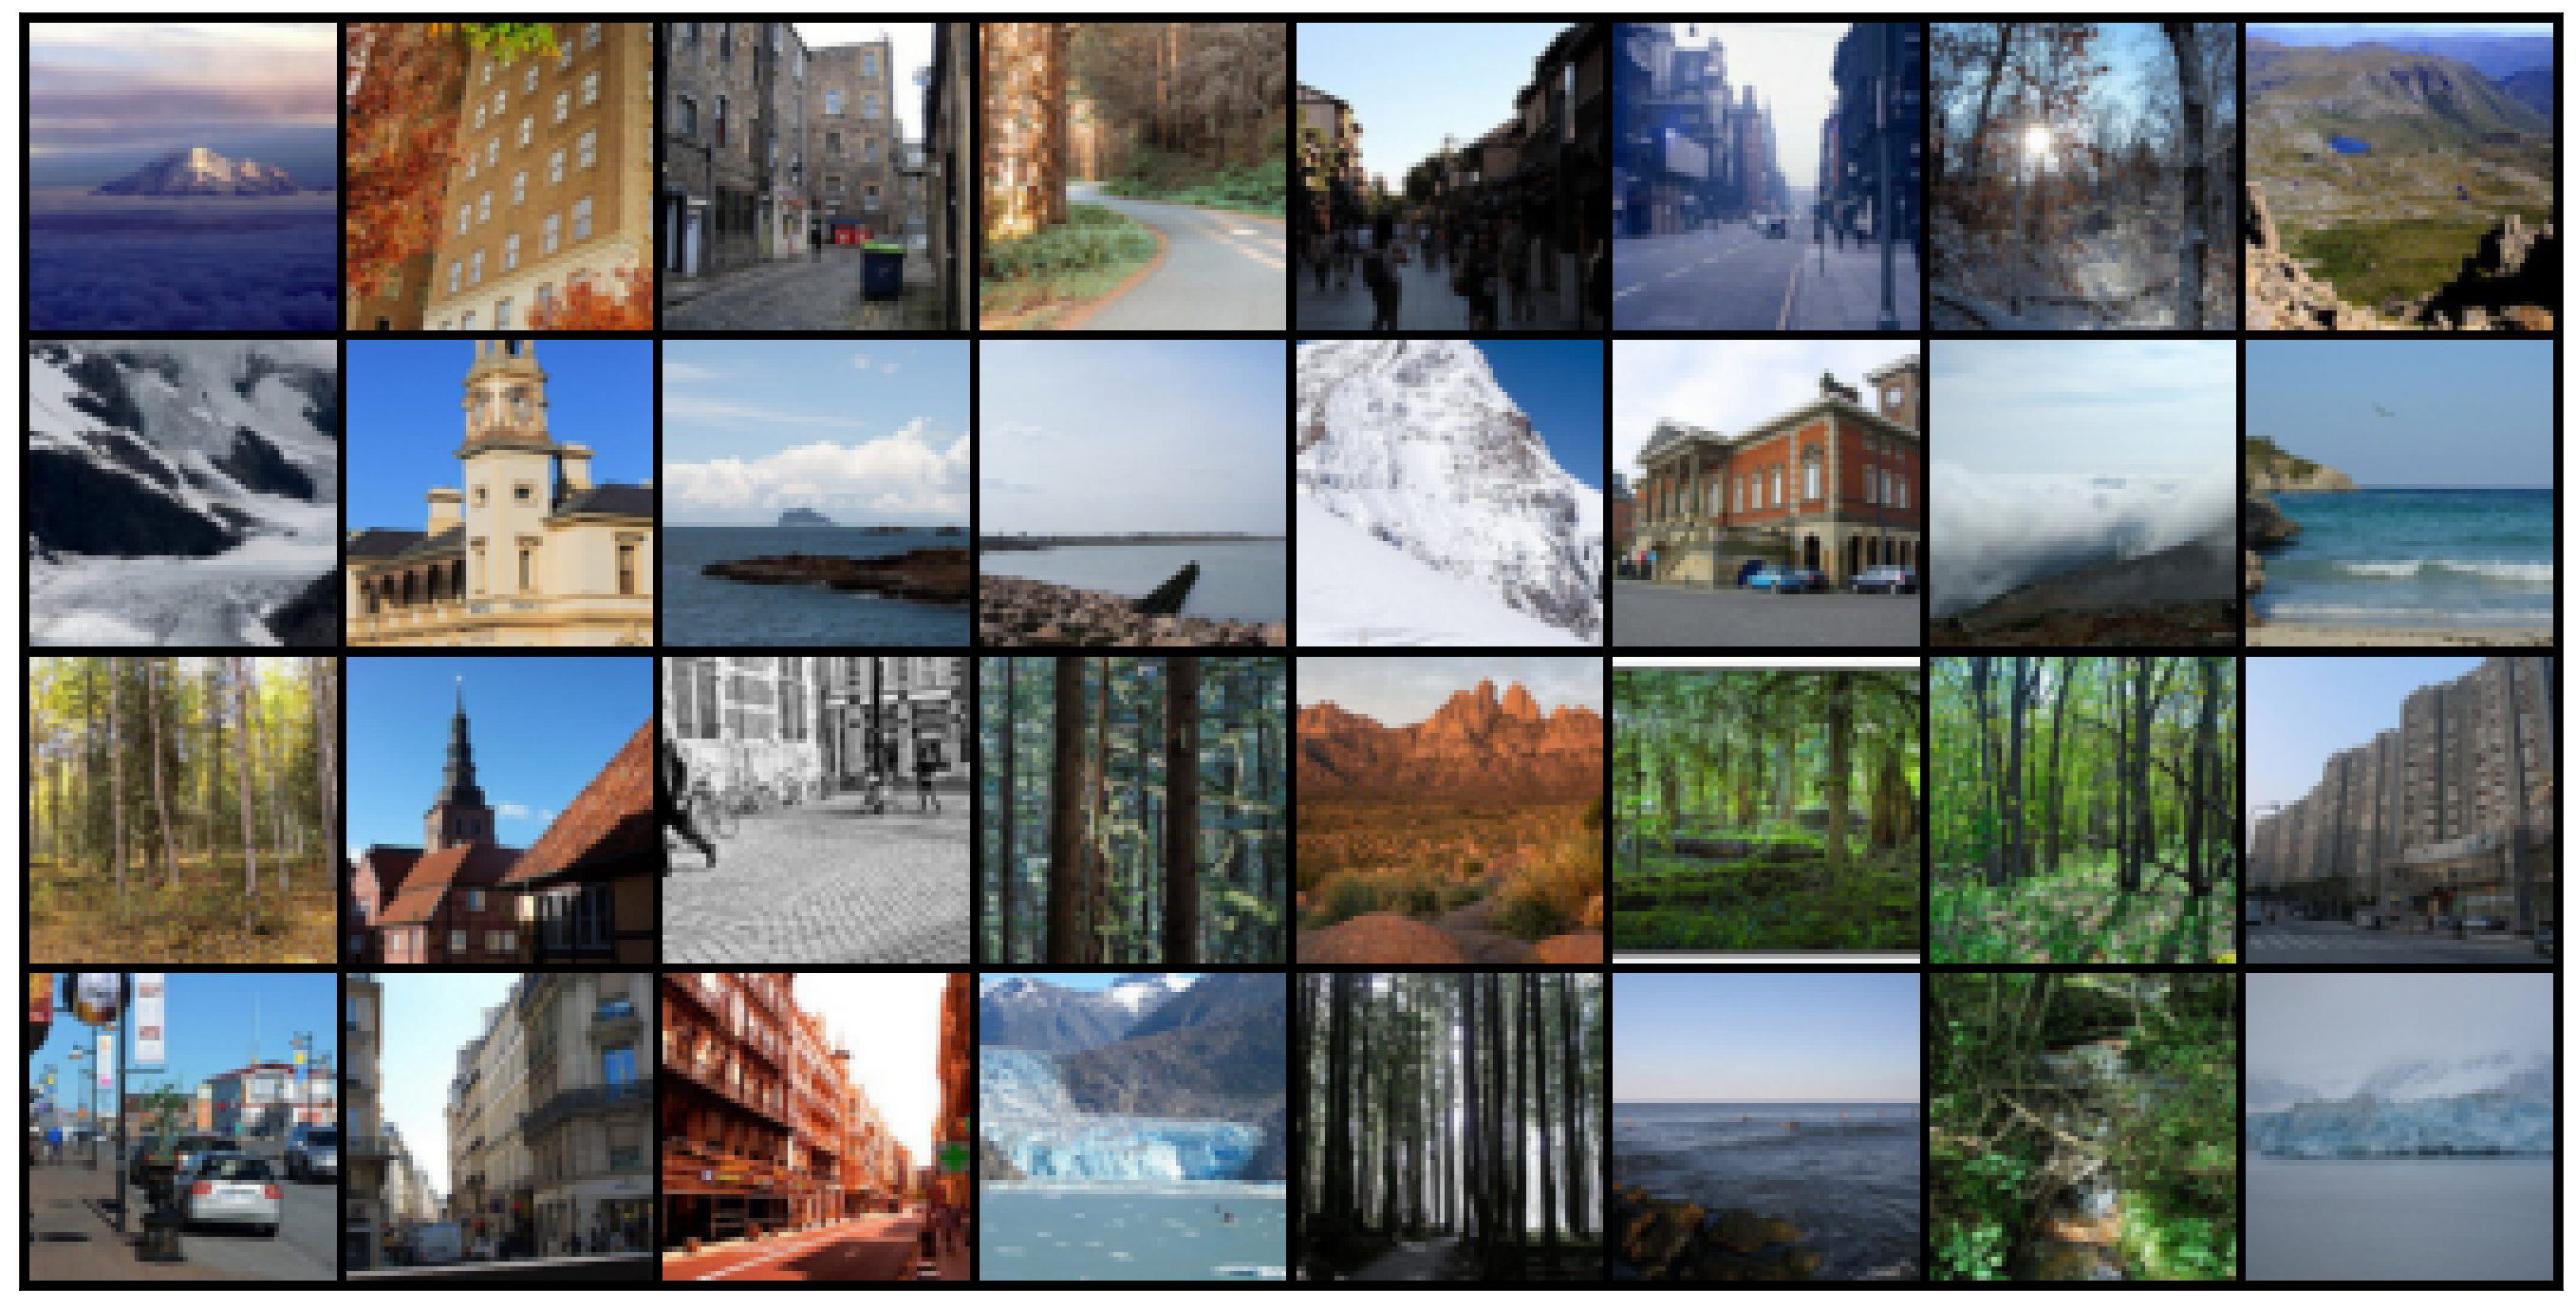

In [11]:
show_batch(train_dl)

In [12]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [13]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [14]:
device = get_default_device()
device

device(type='cuda')

In [15]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [16]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [17]:
no_of_classes = len(train.classes)
no_of_classes

6

In [18]:
model = to_device(ResNet9(3, no_of_classes), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [19]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [20]:
torch.cuda.empty_cache()
#torch.cuda.memory_summary()
#torch.cuda.memory_stats()

In [21]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.7899843454360962, 'val_acc': 0.16804766654968262}]

epoch: a measeure of the number of times all of the training vectors are used once to update the weights.

valid_loss_min: the minimum validation loss, this is needed so that when we continue the training we can start with this rather than np.Inf value.

In [22]:
epochs = 12
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [23]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00211, train_loss: 1.0074, val_loss: 0.8152, val_acc: 0.7103
Epoch [1], last_lr: 0.00603, train_loss: 1.0005, val_loss: 1.3216, val_acc: 0.5575
Epoch [2], last_lr: 0.00936, train_loss: 0.8913, val_loss: 0.6368, val_acc: 0.7581
Epoch [3], last_lr: 0.00994, train_loss: 0.6753, val_loss: 0.7119, val_acc: 0.7473
Epoch [4], last_lr: 0.00933, train_loss: 0.5991, val_loss: 0.6097, val_acc: 0.7872
Epoch [5], last_lr: 0.00812, train_loss: 0.5533, val_loss: 0.6254, val_acc: 0.7628
Epoch [6], last_lr: 0.00647, train_loss: 0.4973, val_loss: 0.4675, val_acc: 0.8378
Epoch [7], last_lr: 0.00463, train_loss: 0.4541, val_loss: 0.4657, val_acc: 0.8338
Epoch [8], last_lr: 0.00283, train_loss: 0.3932, val_loss: 0.4340, val_acc: 0.8520
Epoch [9], last_lr: 0.00133, train_loss: 0.3347, val_loss: 0.3248, val_acc: 0.8871
Epoch [10], last_lr: 0.00035, train_loss: 0.2548, val_loss: 0.3061, val_acc: 0.8884
Epoch [11], last_lr: 0.00000, train_loss: 0.1993, val_loss: 0.2905, val_acc: 0.8939
Wa

In [24]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

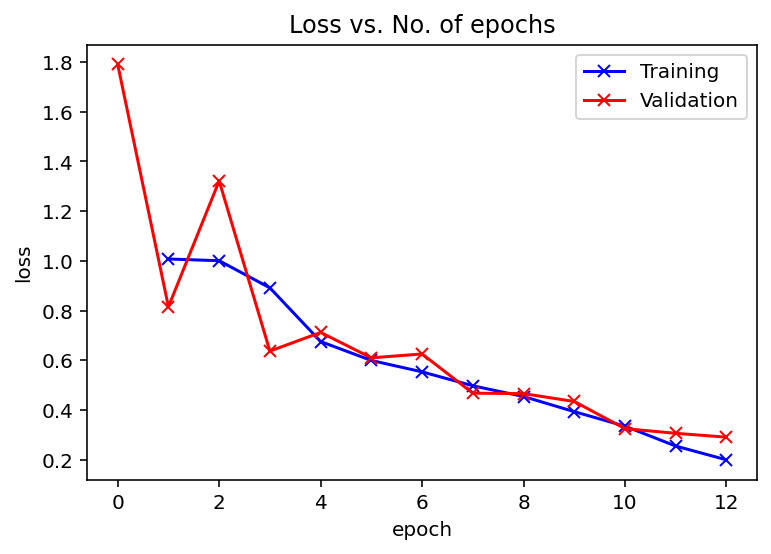

In [25]:
plot_losses(history)

In [26]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

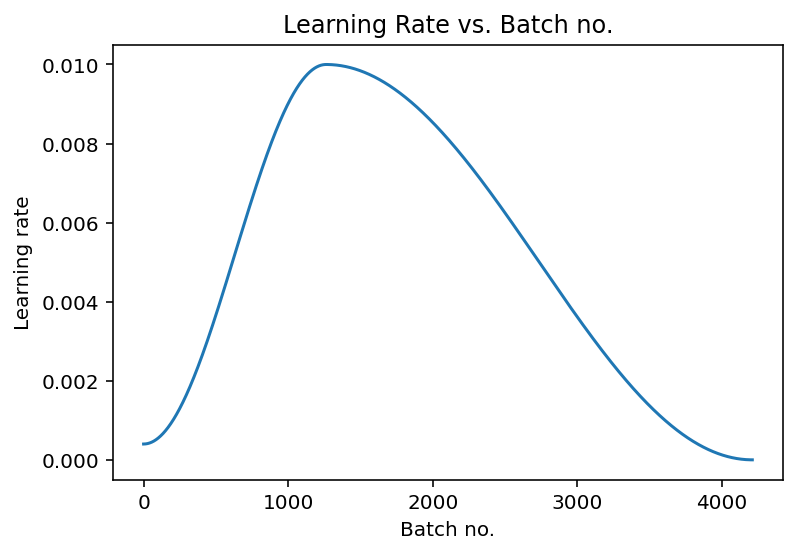

In [27]:
plot_lrs(history)

In [28]:
test_loader1 = DeviceDataLoader(test_dl, device)
result = evaluate(model, test_loader1)
result

{'val_loss': 0.28356945514678955, 'val_acc': 0.8997436165809631}

## Predictions on test dataset

In [29]:
correct_count, all_count = 0, 0
for images, labels in test_dl:
    for i in range(len(labels)):
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        img = images[i].view(1,3,64,64)
        with torch.no_grad():
            logps = model(img)

        ps = torch.exp(logps)
        probab = list(ps.cpu()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.cpu()[i]
        if(true_label == pred_label):
            correct_count += 1
        all_count += 1
print("Number of images Tested:", all_count)
print("\n Model Accuracy:",(correct_count/all_count)*100)

Number of images Tested: 3000

 Model Accuracy: 90.0


In [30]:
def pred_class(img):
    # transform images
    img_tens = test_transform(img)
    # change image format (3,150,150) to (1,3,150,150) by help of unsqueeze function
    # image needs to be in cuda before predition
    img_im = img_tens.unsqueeze(0).cuda() 
    uinput = Variable(img_im)
    uinput = uinput.to(device)
    out = model(uinput)
    # convert image to numpy format in cpu and snatching max prediction score class index
    index = out.data.cpu().numpy().argmax()    
    return index

In [31]:
from PIL import Image
from torch.autograd import Variable

In [32]:
data_dir_pred = r"D:\Image_Analysis\batch3"
pred_files = [os.path.join(data_dir_pred, f) for f in os.listdir(data_dir_pred)]

In [33]:
train_dir = r'D:\Image_Analysis\Image_Analysis\Image Data\archive\seg_train'
outcomes = os.listdir(train_dir)
print(outcomes)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


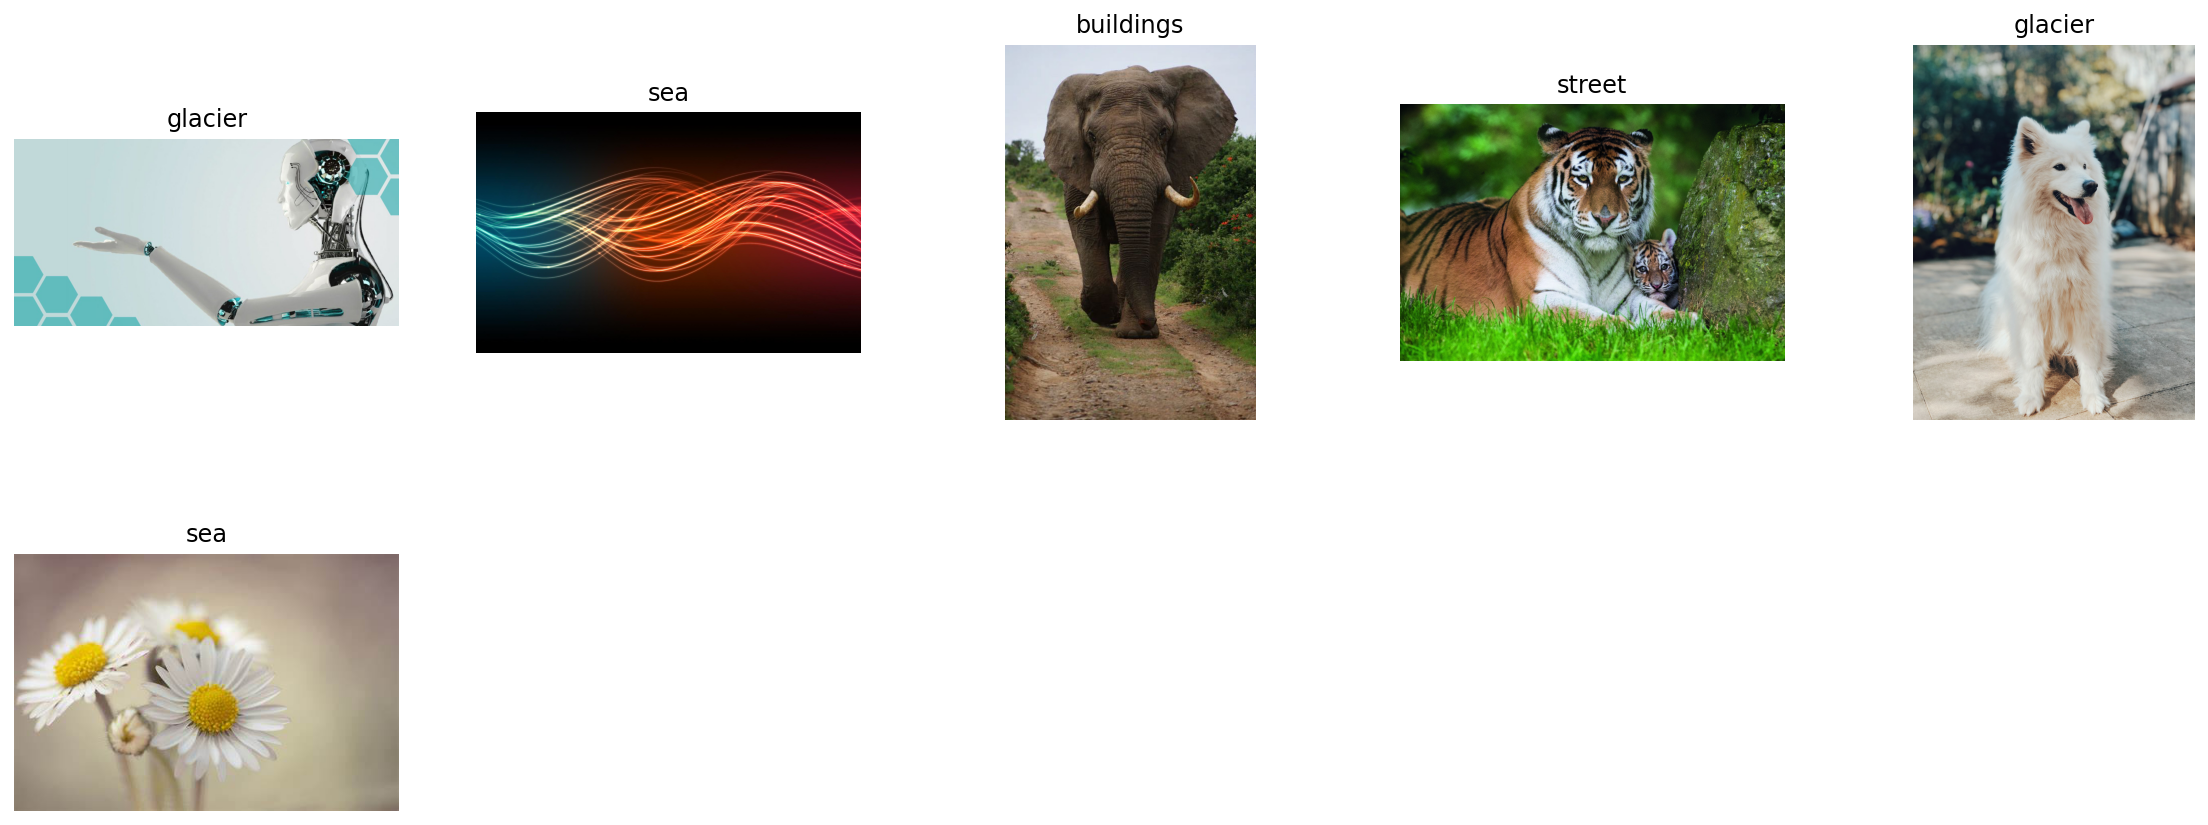

In [34]:
# make class dictionary so i can grab class name by index(key)
classes = {k:v for k , v in enumerate(sorted(outcomes))}
model.eval()


plt.figure(figsize=(20,20))
for i, images in enumerate(pred_files):
    # just want 25 images to print
    if i > 24:break
    img = Image.open(images)
    index = pred_class(img)
    plt.subplot(5,5,i+1)
    plt.title(classes[index])
    plt.axis('off')
    plt.imshow(img)